In [1]:
%reset -f

#numerical computation package for Python
import numpy             as np

#data management package for Python
import pandas            as pd

#Data visualization package for Python
import arviz             as az
import matplotlib.pyplot as plt#you can use seaborn via : import seaborn as sn
#Bayesian package for Python
import pymc3             as pm

#to simplify math formula management
import aesara

# set random seed and plotting details

In [2]:
seed = 0
rng = np.random.default_rng(seed)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

# generating data and population regression equation

In [3]:
size = 200

x  = np.linspace(0, 1, size)
xb = 1 + 2 * x
y  = 1 + 2 * x + np.random.normal(scale=1, size=size)

data = pd.DataFrame(dict(x=x, y=y))

# plot data and population regression equation

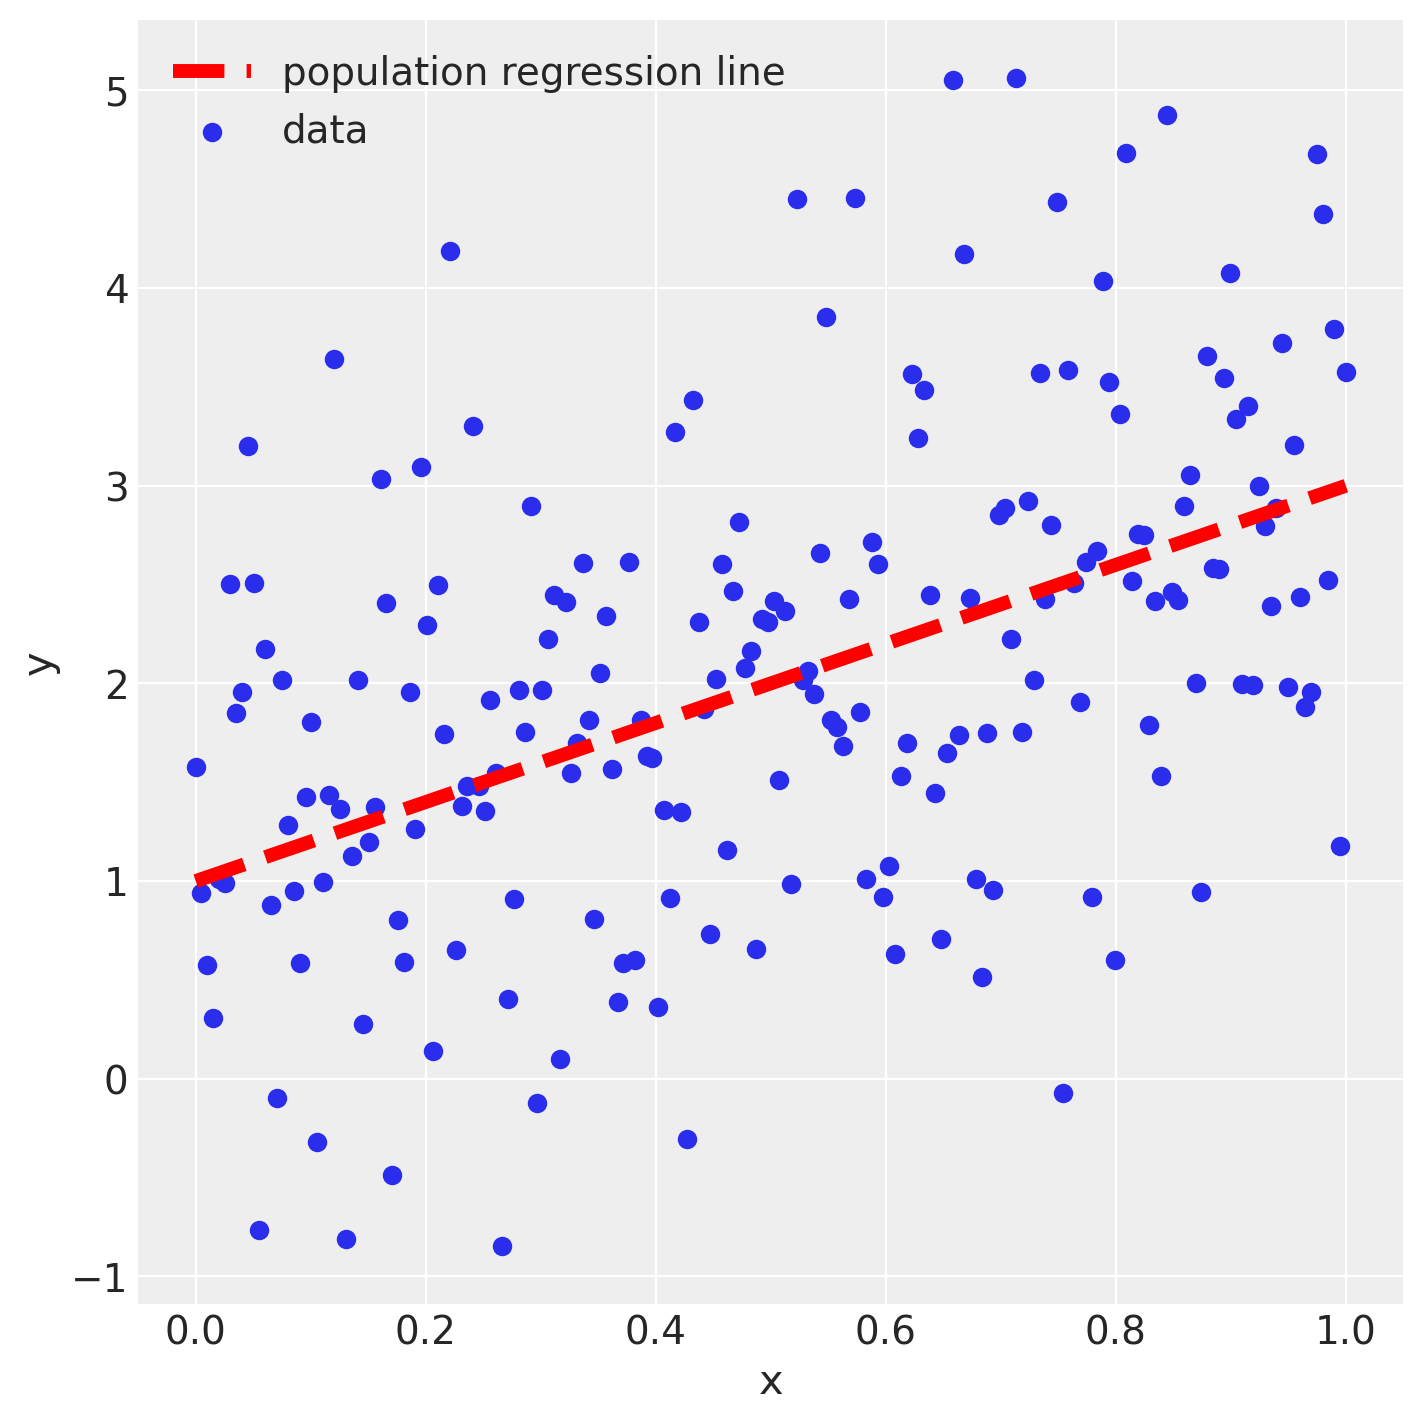

In [37]:
fig = plt.figure(figsize=(7, 7))

plt.scatter(x, y, label="data")
plt.plot(x, xb, label="population regression line", c='red', lw=5, linestyle='dashed')
plt.xlabel('x')
plt.ylabel('y')

plt.legend()
plt.show()

# Baseline : Frequentist OLS

In [6]:
import statsmodels.api as sm

X = data['x']
X = sm.add_constant(X)
Y = data['y']

reg = sm.OLS(Y, X)
result = reg.fit()

print(result.summary())

Y_pred = result.predict()
Y_pred.shape = (200,1)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.212
Method:                 Least Squares   F-statistic:                     54.41
Date:                Sun, 14 Nov 2021   Prob (F-statistic):           4.36e-12
Time:                        16:14:19   Log-Likelihood:                -292.85
No. Observations:                 200   AIC:                             589.7
Df Residuals:                     198   BIC:                             596.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0860      0.148      7.330      0.0

## Frequentist OLS plotting

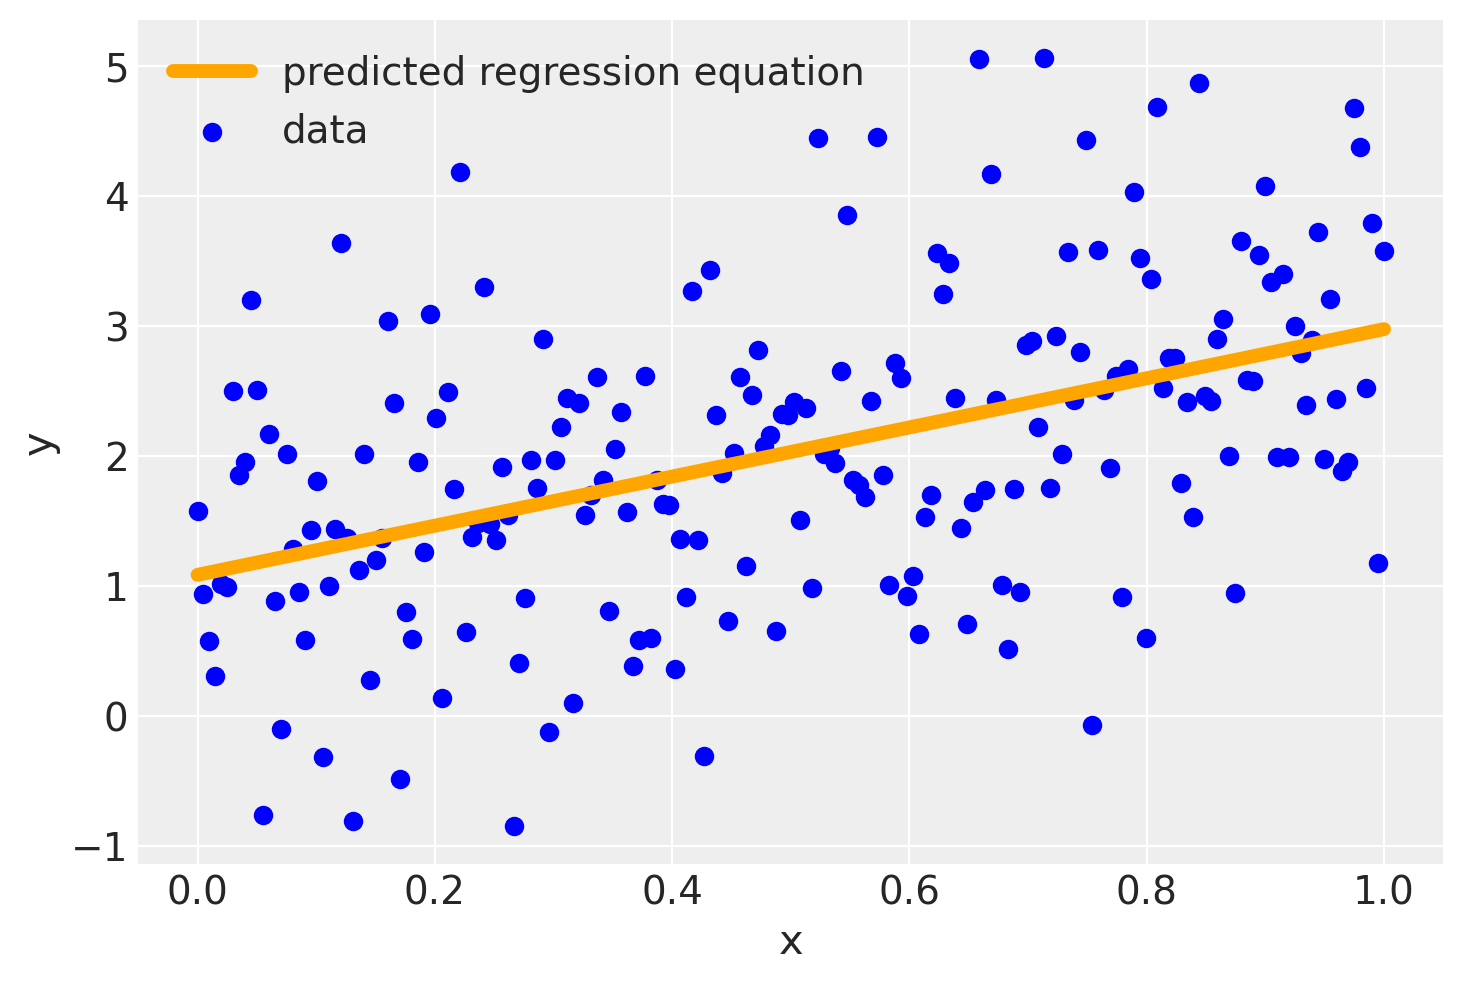

In [7]:
fig1 = plt.figure()

plt.scatter(X['x'], Y, label='data', color='blue')
plt.plot(X['x'], Y_pred, label='predicted regression equation', color='orange', linewidth=5.0)

plt.xlabel('x')
plt.ylabel('y')

plt.legend()
plt.show()

# Bayesian regression 

## define prior, likelihood and calculate posterior

In [8]:
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    x_coeff = pm.Normal("x", 0, sigma=20)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + x_coeff * x, sigma=sigma, observed=y)

    # Inference
    trace = pm.sample(10000, cores=16, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [x, Intercept, sigma]


Sampling 16 chains for 1_000 tune and 10_000 draw iterations (16_000 + 160_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.8815744445609045, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8790620964435075, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.881075690314056, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8861359742884665, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8865647059839528, but should be close to 0.8. Try to increase the number of tuning steps.


## if you wanto simplify your code of last step

In [9]:
with pm.Model() as model:
    pm.glm.GLM.from_formula("y ~ x", data)
    trace = pm.sample(10000, cores=16)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [sd, x, Intercept]


Sampling 16 chains for 1_000 tune and 10_000 draw iterations (16_000 + 160_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.8788955436148326, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8910935057513282, but should be close to 0.8. Try to increase the number of tuning steps.


# check the posterior of each coefficient

/home/ning/miniforge3/envs/bayesian/lib/python3.9/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


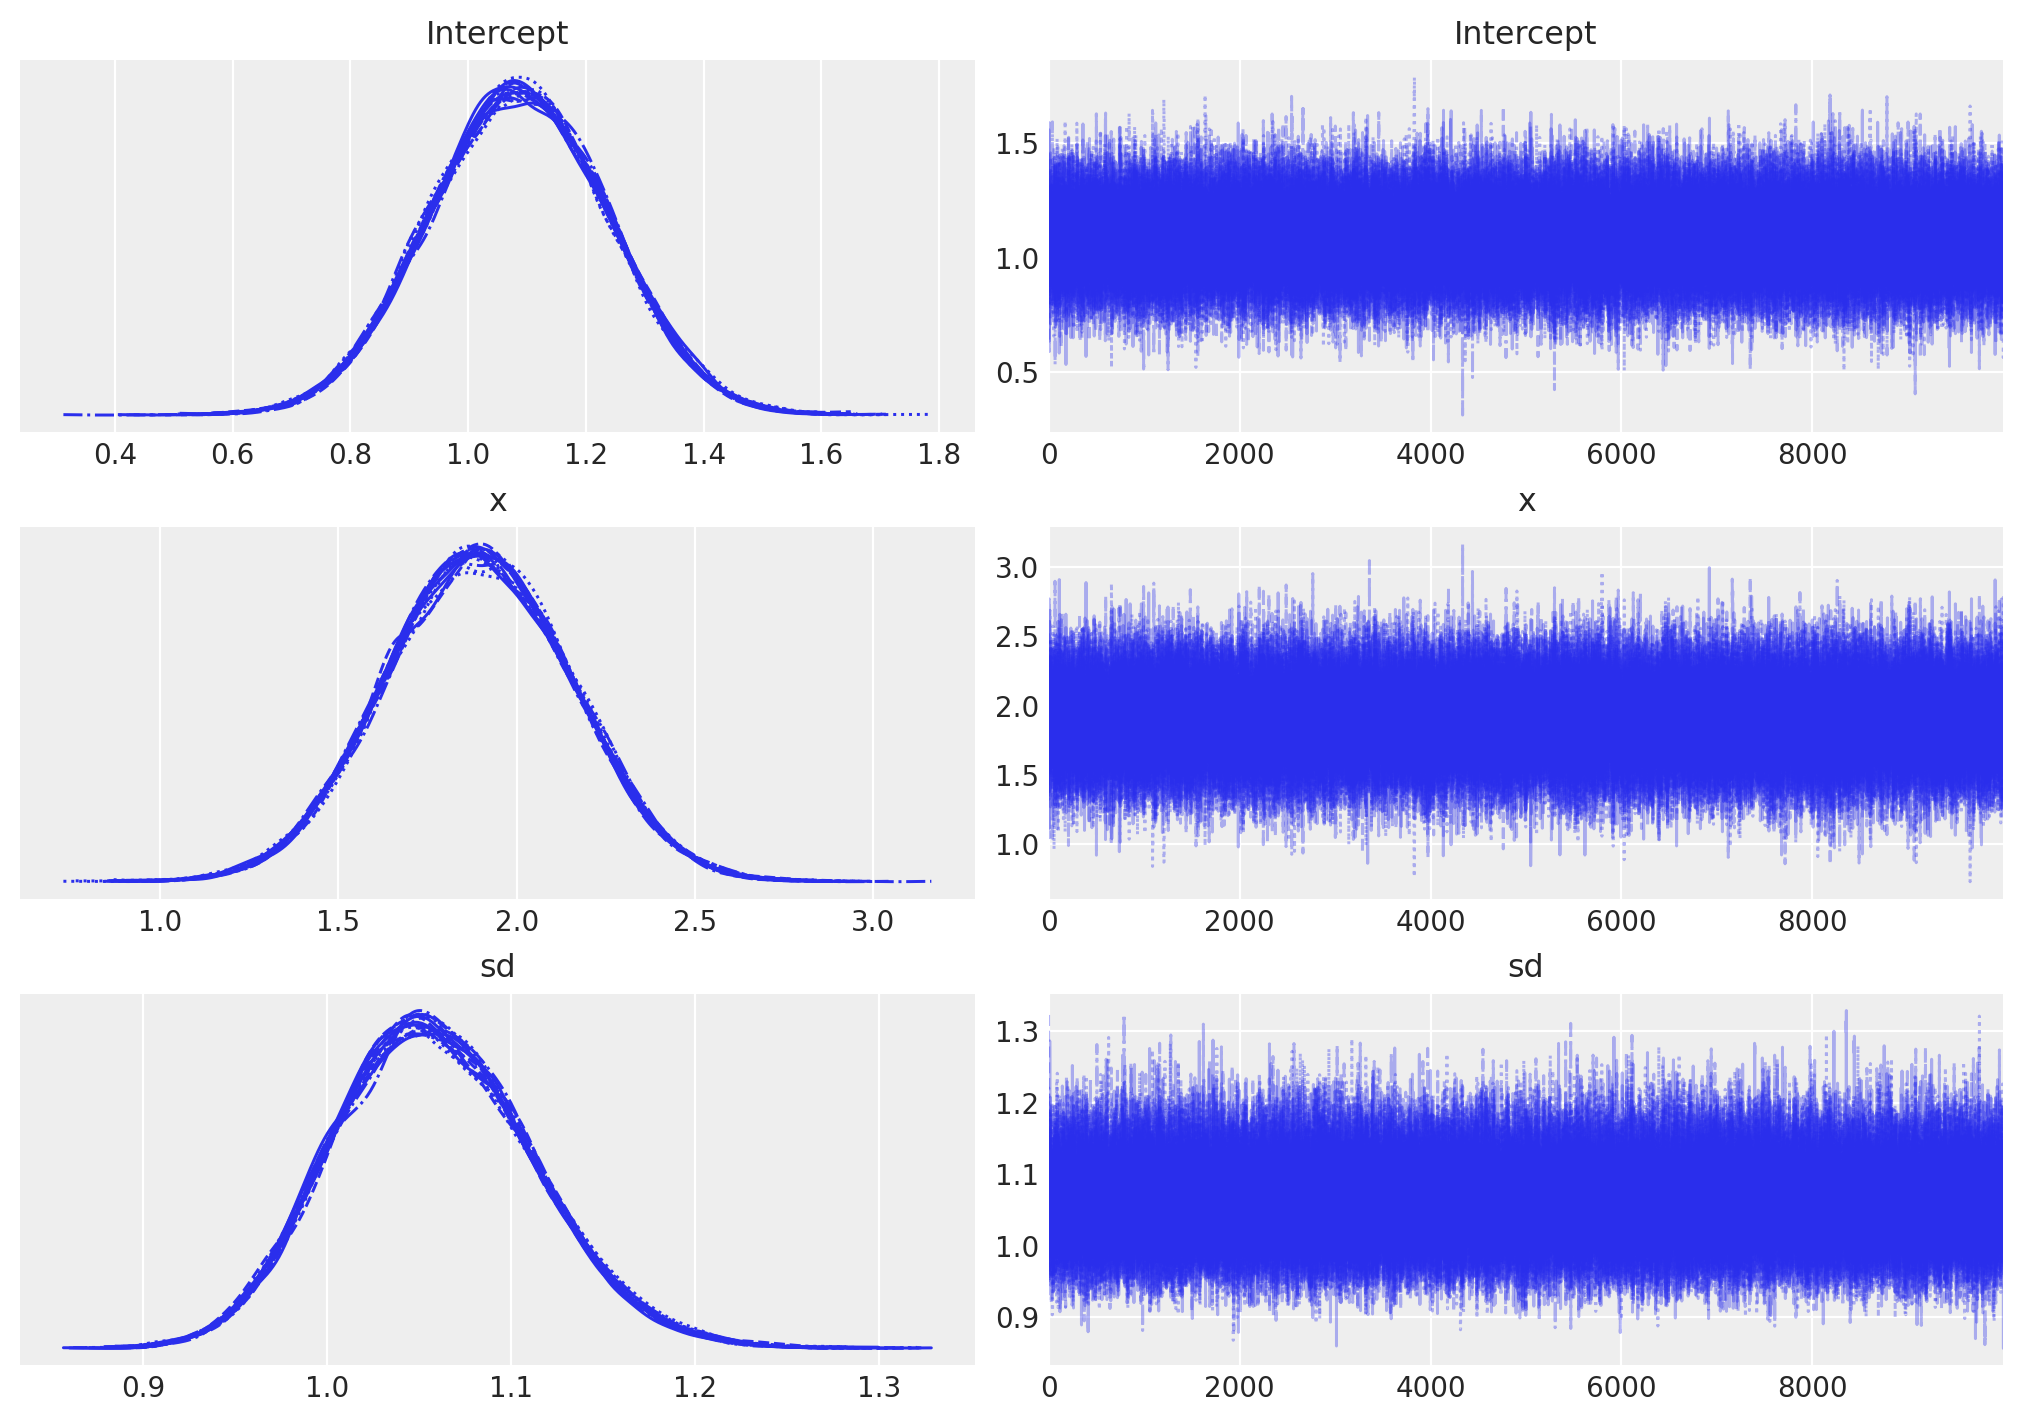

In [10]:
az.plot_trace(trace, figsize=(10, 7));

# Bayesian regression plot

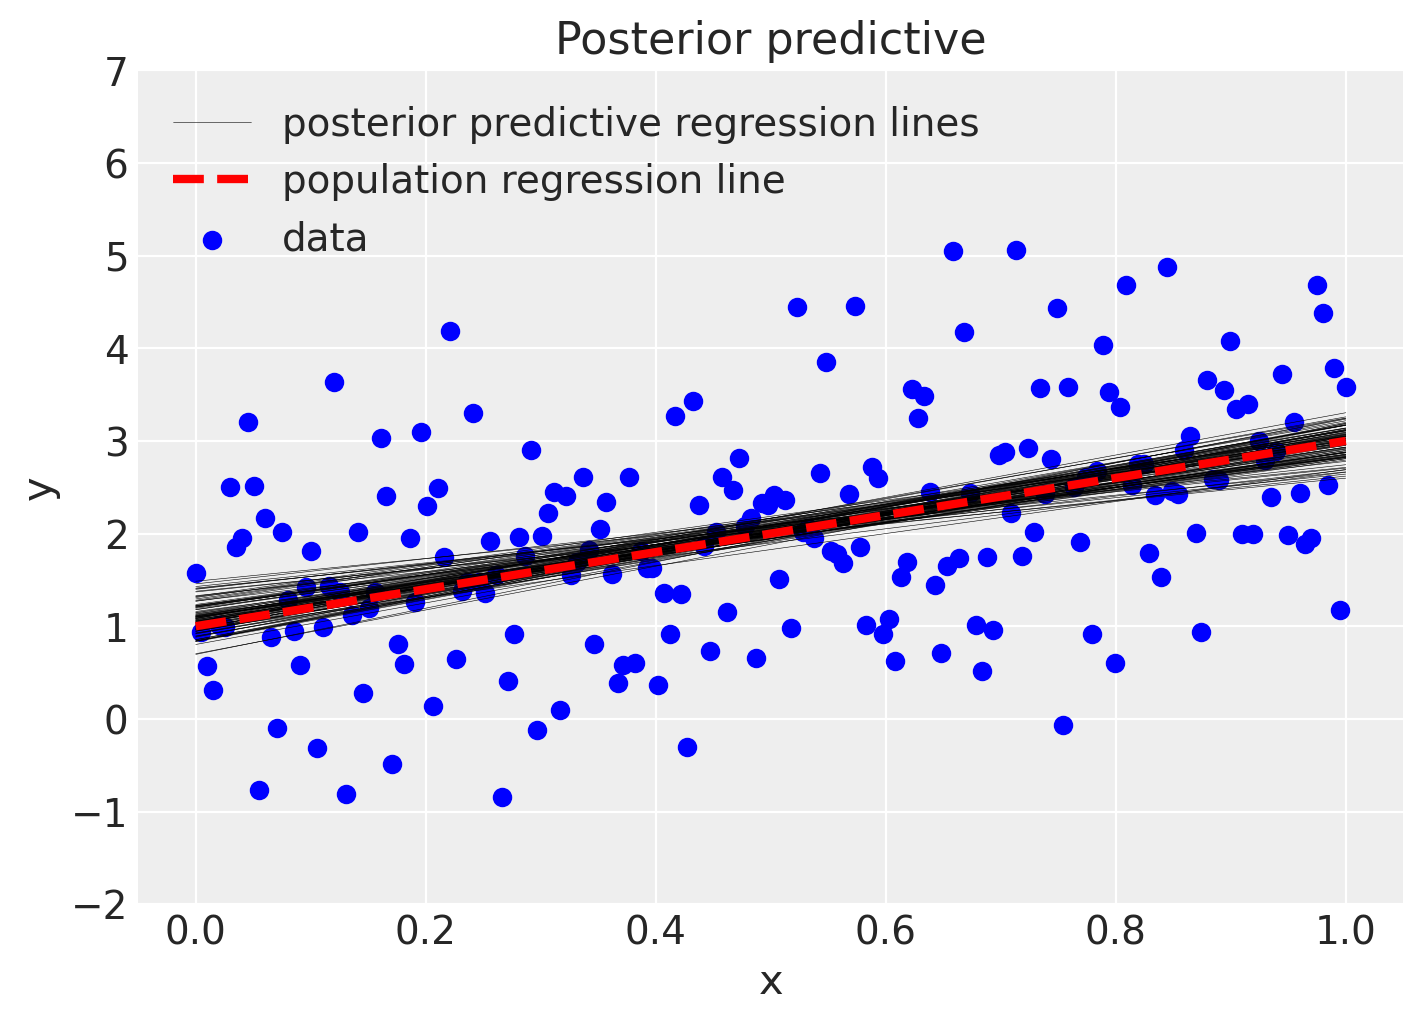

In [36]:
plt.figure(figsize=(7, 5))

plt.scatter(x, y, c='blue', label="data")
pm.plot_posterior_predictive_glm(trace, samples=100, label="posterior predictive regression lines")
plt.plot(x, xb, label="population regression line", lw=3.0, c="r", linestyle='dashed')

plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-2,7)

plt.legend()

plt.show()

# OLS vs Bayesian Regression

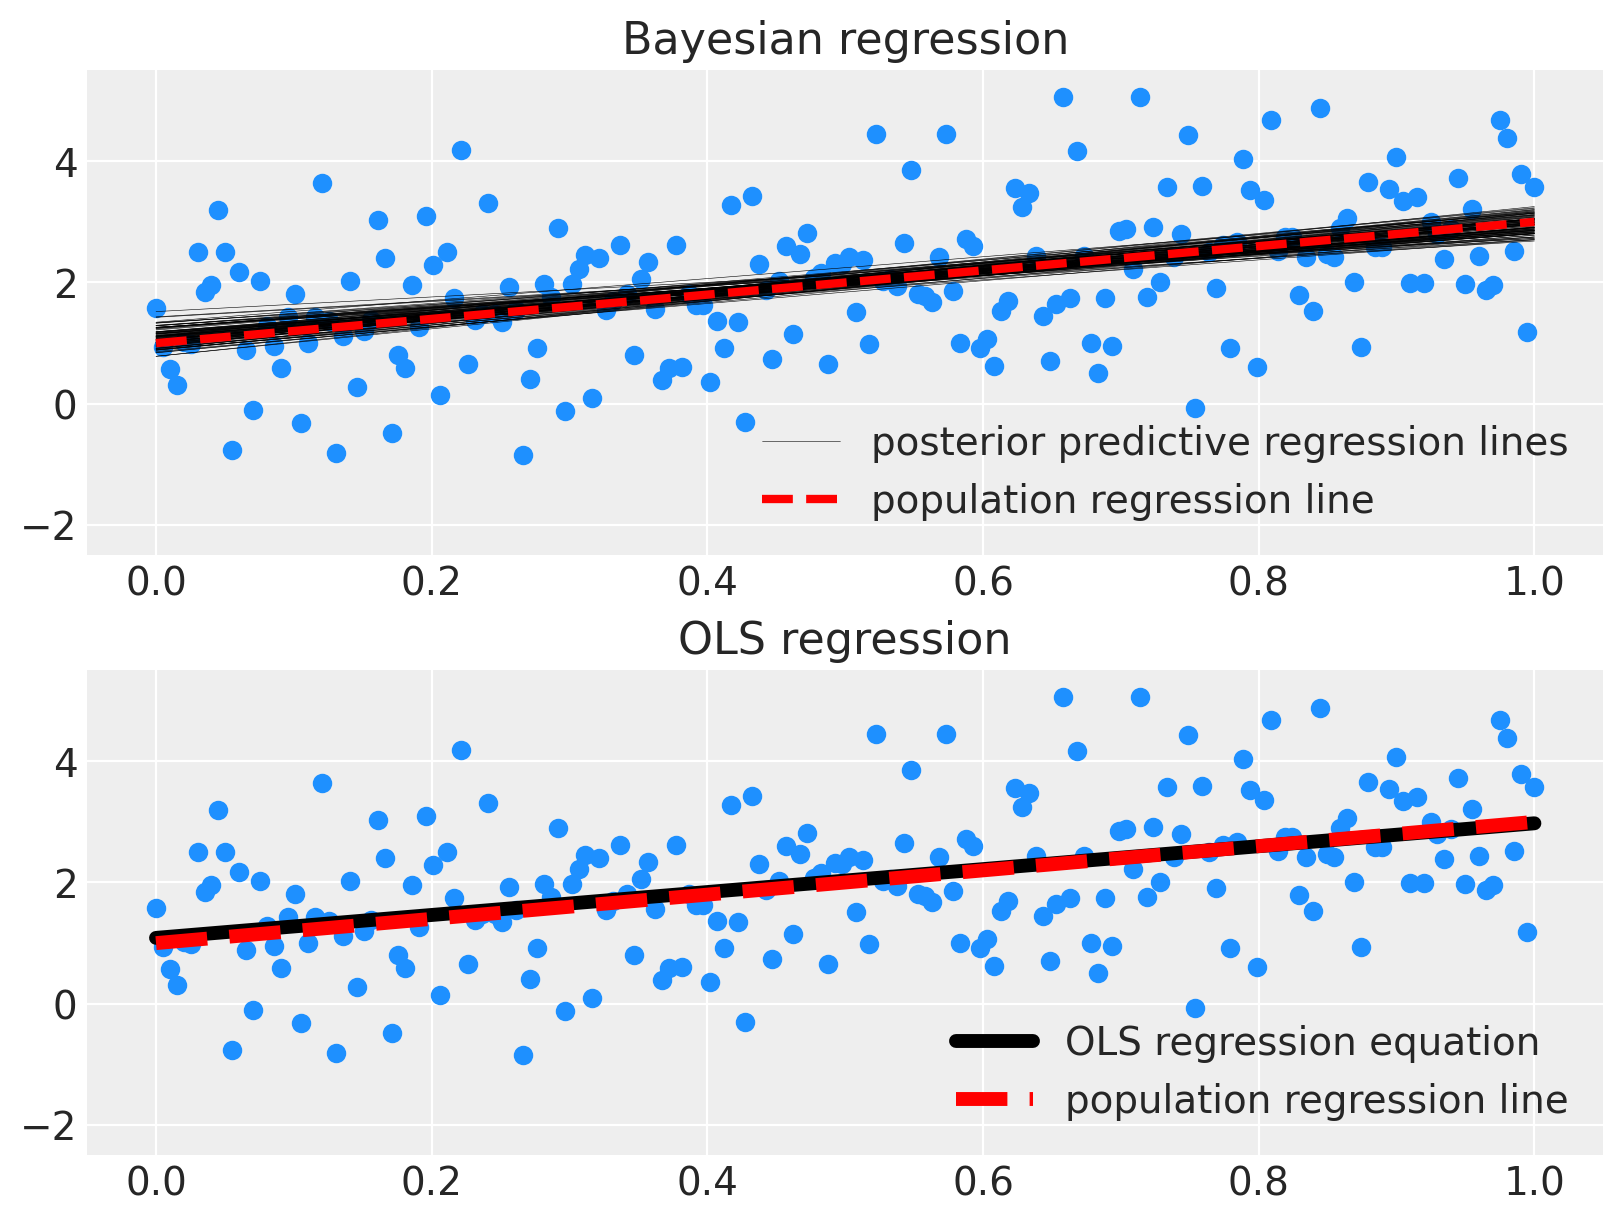

In [54]:
fig = plt.subplots(figsize=(8,6))

plt.subplot(2, 1, 1)
plt.scatter(x, y, c='dodgerblue')
pm.plot_posterior_predictive_glm(trace, samples=100, label="posterior predictive regression lines")
plt.plot(x, xb, label="population regression line", lw=3.0, c="r", linestyle='dashed')
plt.title("Bayesian regression")
plt.ylim(-2.5,5.5)
plt.legend()


plt.subplot(2, 1, 2)
plt.scatter(x, y, c='dodgerblue')
plt.plot(X['x'], Y_pred, label='OLS regression equation', c='k', linewidth=5.0)
plt.plot(x, xb, label="population regression line", lw=5.0, c="r", linestyle='dashed')
plt.title("OLS regression")
plt.ylim(-2.5,5.5)
plt.legend()

plt.show()